In [ ]:
#https://platform.stability.ai/docs/legacy/grpc-api/features/inpainting#Python

In [4]:
import os
import io
import warnings

from PIL import Image
from stability_sdk import client
import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation
from torchvision.transforms import GaussianBlur

# Our host url should not be prepended with "https" nor should it have a trailing slash.
os.environ['STABILITY_HOST'] = 'grpc.stability.ai:443'

# Sign up for an account at the following link to get an API Key.
# https://platform.stability.ai/

# Click on the following link once you have created an account to be taken to your API Key.
# https://platform.stability.ai/account/keys


os.environ['STABILITY_KEY'] = 'sk-yA7ggWKUgcgSaQQleVTo55CIy0mDWYablT0ZZ31WgpuACt0O'

# Set up our connection to the API.
stability_api = client.StabilityInference(
    key=os.environ['STABILITY_KEY'], # API Key reference.
    verbose=True, # Print debug messages.
    engine="stable-diffusion-xl-1024-v1-0", # Set the engine to use for generation.
    # Check out the following link for a list of available engines: https://platform.stability.ai/docs/features/api-parameters#engine
)

In [8]:
img = Image.open('/Users/santiagowon/Dropbox/Santiago/01. Maestria/Tesis/11_Project_Analysed_DB/1 summary missing/Avatar_The_Last_Airbender/scenes_output/scene_137_frame_13123.jpg')
# Open the mask image
mask_o = Image.open('/Users/santiagowon/Dropbox/Santiago/01. Maestria/Tesis/11_Project_Analysed_DB/mask_18.png')
mask_i = Image.eval(mask_o, lambda x: 255 - x)

# Feathering the edges of our mask generally helps provide a better result. Alternately, you can feather the mask in a suite like Photoshop or GIMP.

blur = GaussianBlur(11,20)
mask = blur(mask_i)

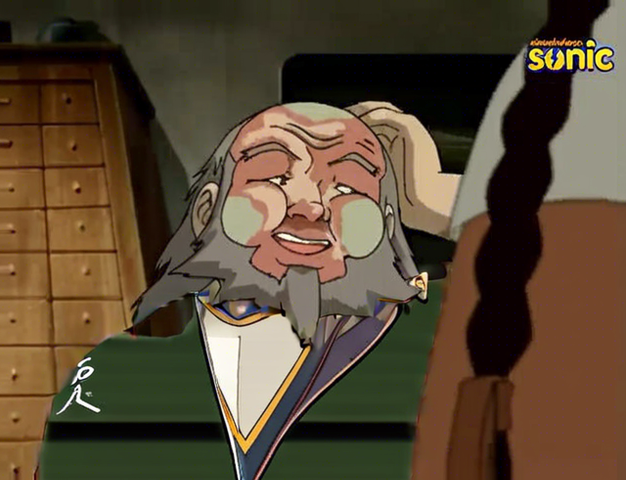

In [14]:
answers = stability_api.generate(
    prompt="this mask is the frontal shape torso of a person i want to make it be the shape of a shirt of a chinese uncle with the style of the avatar the last airbender",
    init_image=img,
    mask_image=mask,
    start_schedule=1,
    seed=44332211, # If attempting to transform an image that was previously generated with our API,
                   # initial images benefit from having their own distinct seed rather than using the seed of the original image generation.
    steps=50, # Amount of inference steps performed on image generation. Defaults to 30.
    cfg_scale=8.0, # Influences how strongly your generation is guided to match your prompt.
                   # Setting this value higher increases the strength in which it tries to match your prompt.
                   # Defaults to 7.0 if not specified.
    width=1024, # Generation width, if not included defaults to 512 or 1024 depending on the engine.
    height=1024, # Generation height, if not included defaults to 512 or 1024 depending on the engine.
    sampler=generation.SAMPLER_K_DPMPP_2M # Choose which sampler we want to denoise our generation with.
                                                 # Defaults to k_lms if not specified. Clip Guidance only supports ancestral samplers.
                                                 # (Available Samplers: ddim, plms, k_euler, k_euler_ancestral, k_heun, k_dpm_2, k_dpm_2_ancestral, k_dpmpp_2s_ancestral, k_lms, k_dpmpp_2m, k_dpmpp_sde)
)

# Set up our warning to print to the console if the adult content classifier is tripped.
# If adult content classifier is not tripped, save generated image.
for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            global img2
            img2 = Image.open(io.BytesIO(artifact.binary))
            img2.save(str(artifact.seed)+ ".png") # Save our completed image with its seed number as the filename.

img2